In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
pip install missingno


Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install lightgbm

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import csv

In [6]:
train = pd.read_csv("usecase_4_.csv")
test = pd.read_csv("usecase_4_.csv")

In [7]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(pd.DataFrame({"NA_COUNT":dataframe.isnull().sum(),
                        "NA_RATIO":dataframe.isnull().sum() / len(dataframe)}))
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [8]:
check_df(train)

##################### Shape #####################
(20676, 29)
##################### Types #####################
NCT Number                    object
Study Title                   object
Study URL                     object
Study Status                  object
Brief Summary                 object
Study Results                 object
Conditions                    object
Interventions                 object
Primary Outcome Measures      object
Secondary Outcome Measures    object
Other Outcome Measures        object
Sponsor                       object
Collaborators                 object
Sex                           object
Age                           object
Phases                        object
Enrollment                     int64
Funder Type                   object
Study Type                    object
Study Design                  object
Other IDs                     object
Start Date                    object
Primary Completion Date       object
Completion Date               object


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
train.shape

In [ ]:
train.info()

In [ ]:
train['Start Date'] = pd.to_datetime(train['Start Date'])
train['Completion Date'] = pd.to_datetime(train['Completion Date'])
train['duration_days'] = (train['Completion Date'] - train['Start Date']).dt.days
train.to_csv("updated_train.csv", index=False)

In [ ]:
train.info()

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Grabs the columns which are categorical, numerical, categorical but cardinal, and numerical but categorical.
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O" or ("id" in col)]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, cat_but_car, num_cols, num_but_cat

In [11]:
categorical_cols, categorical_but_cardinal, numeric_cols, numeric_but_categorical = grab_col_names(train)

Observations: 20676
Variables: 29
cat_cols: 7
num_cols: 1
cat_but_car: 21
num_but_cat: 0


In [12]:
print("Categorical columns : {}".format(categorical_cols))
print("="*80)
print("Cat_But_Car columns : {}".format(categorical_but_cardinal))
print("="*80)
print("Numeric columns : {}".format(numeric_cols))
print("="*80)
print("Num_But_Cat columns : {}".format(numeric_but_categorical))

Categorical columns : ['Study Status', 'Study Results', 'Sex', 'Age', 'Phases', 'Funder Type', 'Study Type']
Cat_But_Car columns : ['NCT Number', 'Study Title', 'Study URL', 'Brief Summary', 'Conditions', 'Interventions', 'Primary Outcome Measures', 'Secondary Outcome Measures', 'Other Outcome Measures', 'Sponsor', 'Collaborators', 'Study Design', 'Other IDs', 'Start Date', 'Primary Completion Date', 'Completion Date', 'First Posted', 'Results First Posted', 'Last Update Posted', 'Locations', 'Study Recruitment Rate']
Numeric columns : ['Enrollment']
Num_But_Cat columns : []


In [13]:
def cat_summary(dataframe, col_name, plot=False):
    # Shows summary of categorical columns.
    df = pd.DataFrame ({col_name: dataframe[col_name].value_counts (),
                          "Ratio": 100 * dataframe[col_name].value_counts () / len (dataframe)})
    print(df)

    if plot:
        plt.figure(figsize=(7,7))
        plt.pie (df["Ratio"], labels=df.index, 
                labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, autopct = "%1.1f%%",
                pctdistance=0.85, textprops={'fontsize': 10})
     
        #draw circle
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.show();
        print("="*50)

In [32]:
train.nunique()

NCT Number                    20676
Study Title                   20636
Study URL                     20676
Study Status                      8
Brief Summary                 20528
Study Results                     2
Conditions                     7860
Interventions                 18217
Primary Outcome Measures      20437
Secondary Outcome Measures    17646
Other Outcome Measures         1718
Sponsor                        4455
Collaborators                  2768
Sex                               3
Age                               6
Phases                            5
Enrollment                     1341
Funder Type                       8
Study Type                        1
Study Design                    340
Other IDs                     20669
Start Date                     3221
Primary Completion Date        3180
Completion Date                3027
First Posted                   2633
Results First Posted           1716
Last Update Posted             1830
Locations                   

In [33]:
def cat_summary(dataframe, col_name, plot=False):
    # Shows summary of categorical columns.
    df = pd.DataFrame ({col_name: dataframe[col_name].value_counts (),
                          "Ratio": 100 * dataframe[col_name].value_counts () / len (dataframe)})
    print(df)

    if plot:
        plt.figure(figsize=(7,7))
        plt.pie (df["Ratio"], labels=df.index, 
                labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, autopct = "%1.1f%%",
                pctdistance=0.85, textprops={'fontsize': 10})
     
        #draw circle
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.show();
        print("="*50)

                         Study Status      Ratio
Study Status                                    
COMPLETED                       15939  77.089379
TERMINATED                       3215  15.549429
UNKNOWN                          1108   5.358870
ACTIVE_NOT_RECRUITING             182   0.880248
RECRUITING                        181   0.875411
SUSPENDED                          22   0.106404
NOT_YET_RECRUITING                 18   0.087057
ENROLLING_BY_INVITATION            11   0.053202


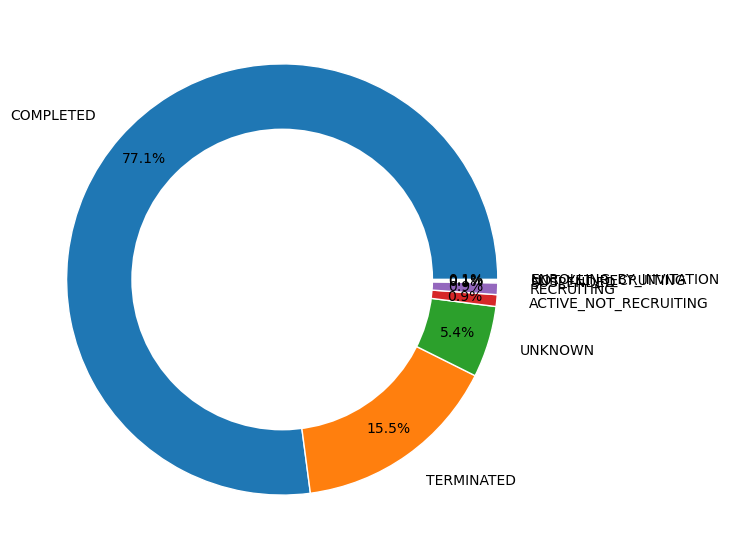

               Study Results      Ratio
Study Results                          
NO                     13002  62.884504
YES                     7674  37.115496


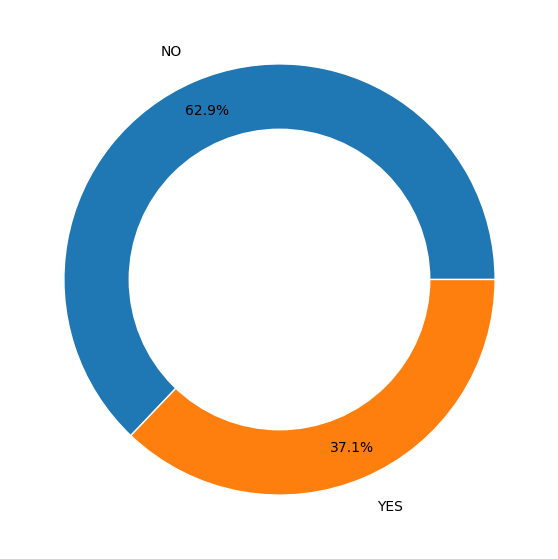

          Sex      Ratio
Sex                     
ALL     18128  87.676533
MALE     1604   7.757787
FEMALE    938   4.536661


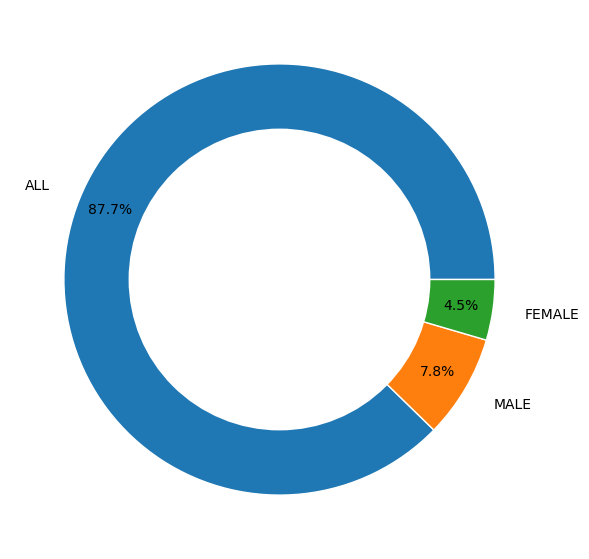

                             Age      Ratio
Age                                        
ADULT, OLDER_ADULT         13727  66.390985
ADULT                       4884  23.621590
CHILD, ADULT, OLDER_ADULT    882   4.265815
CHILD                        705   3.409750
CHILD, ADULT                 394   1.905591
OLDER_ADULT                   84   0.406268


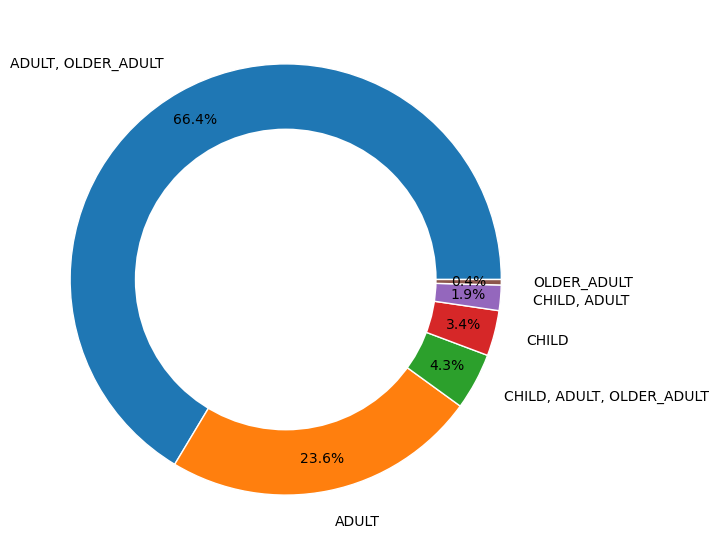

               Phases      Ratio
Phases                          
PHASE1           9166  44.331592
PHASE2           5534  26.765332
PHASE3           4000  19.346102
PHASE1|PHASE2    1594   7.709422
PHASE2|PHASE3     382   1.847553


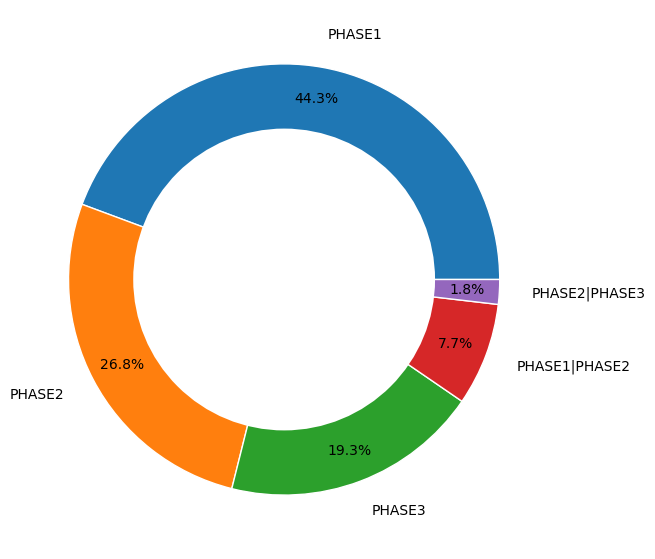

             Funder Type      Ratio
Funder Type                        
INDUSTRY           18322  88.614819
OTHER               2196  10.621010
NIH                   55   0.266009
NETWORK               45   0.217644
OTHER_GOV             43   0.207971
FED                    9   0.043529
INDIV                  5   0.024183
UNKNOWN                1   0.004837


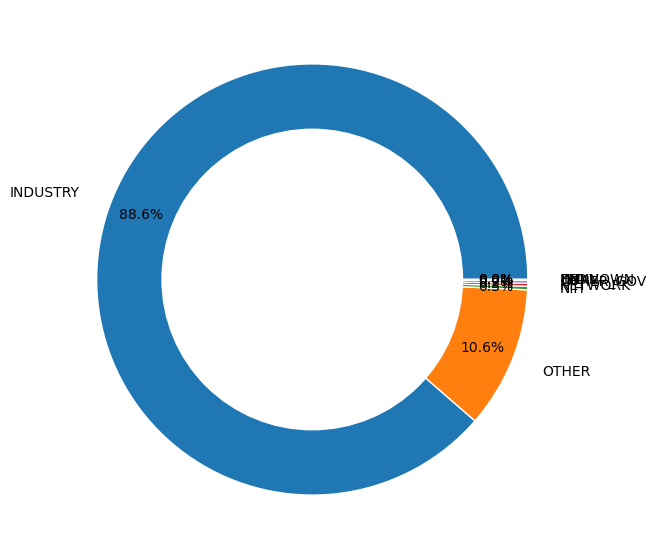

                Study Type  Ratio
Study Type                       
INTERVENTIONAL       20676  100.0


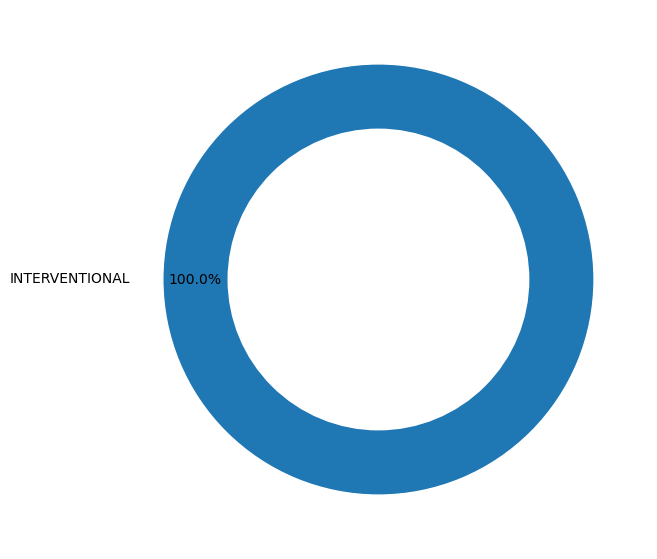

In [14]:
graph_cols = [col for col in categorical_cols if train[col].nunique() < 40]
for col in graph_cols:
    cat_summary (train, col, plot=True)
    

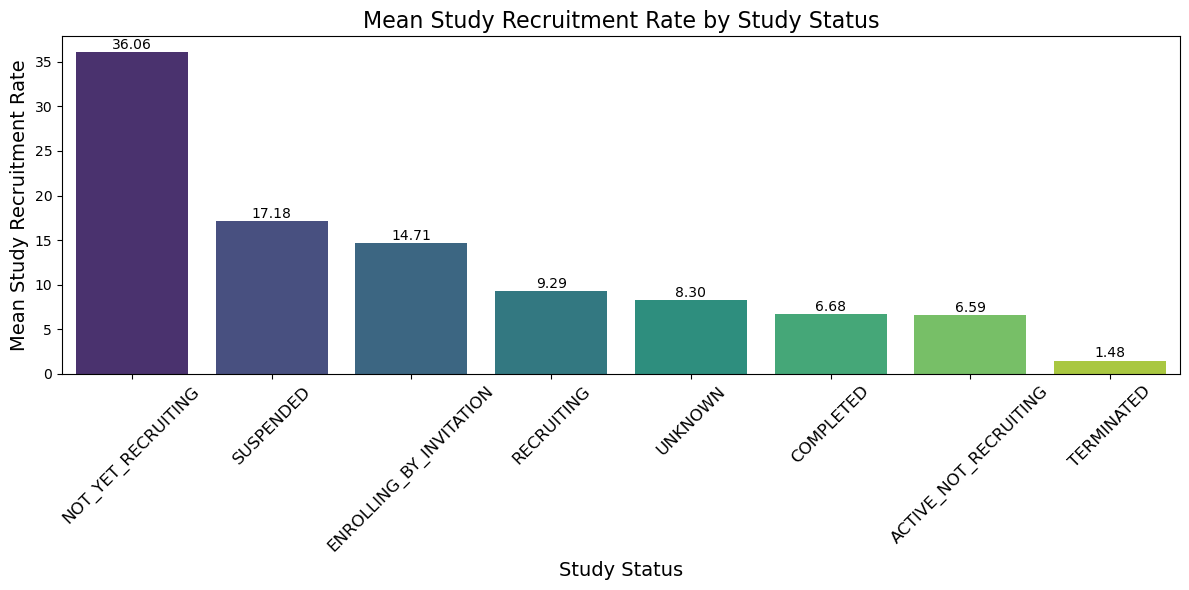

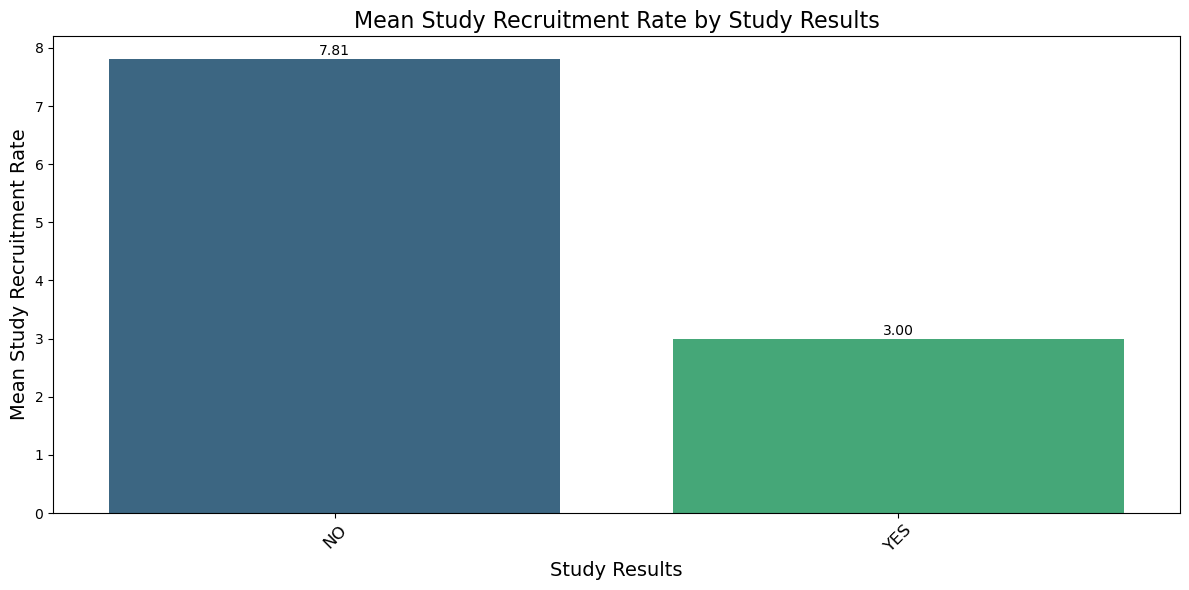

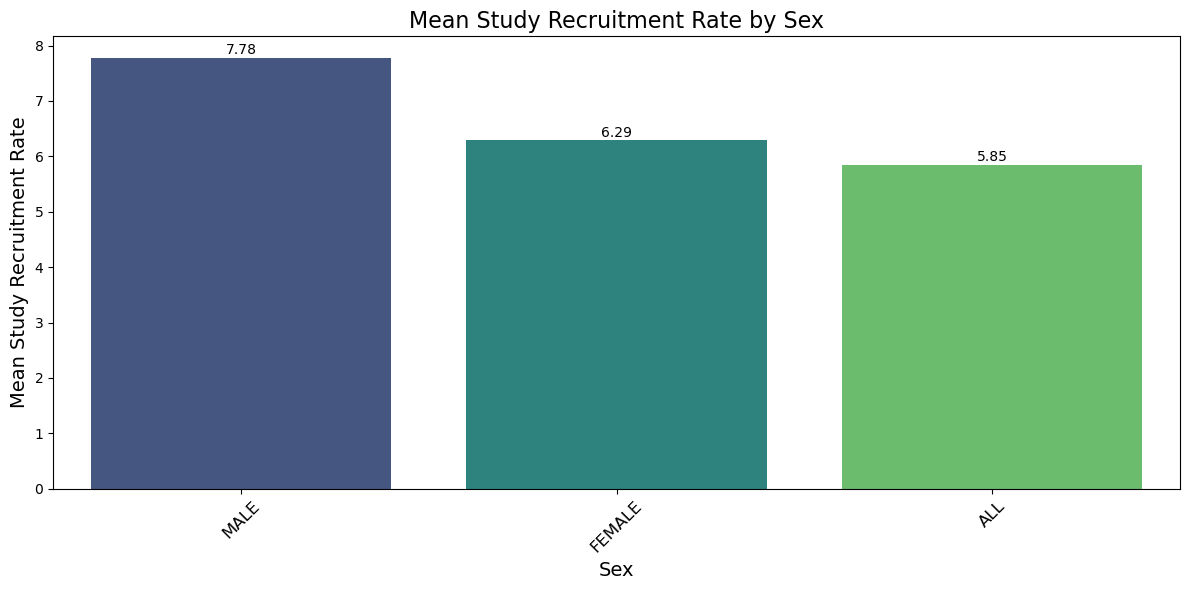

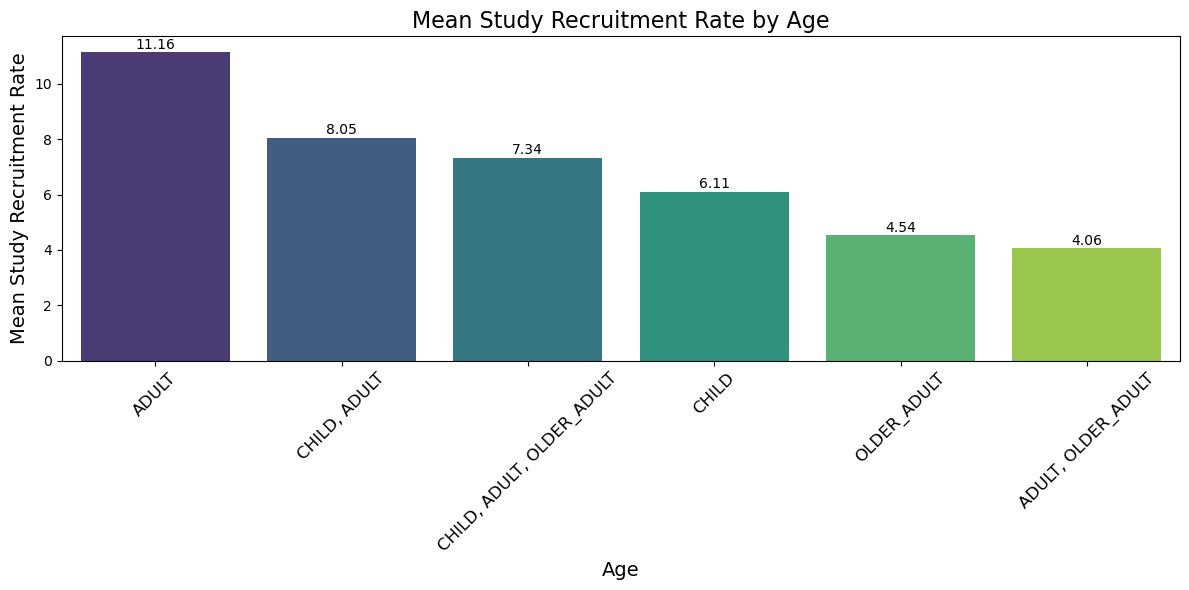

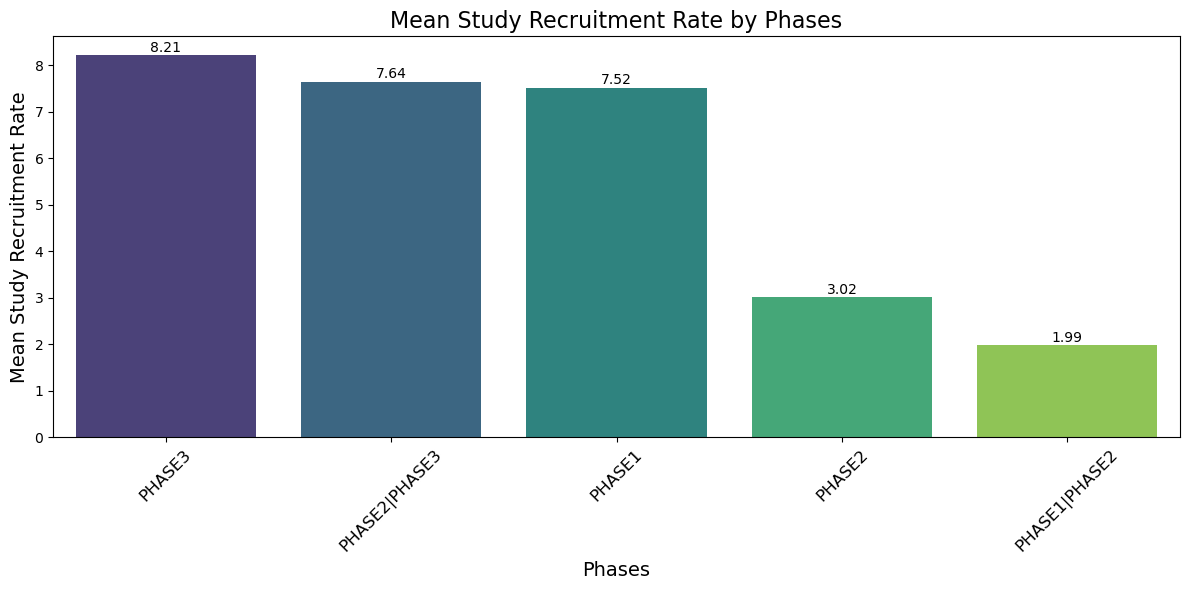

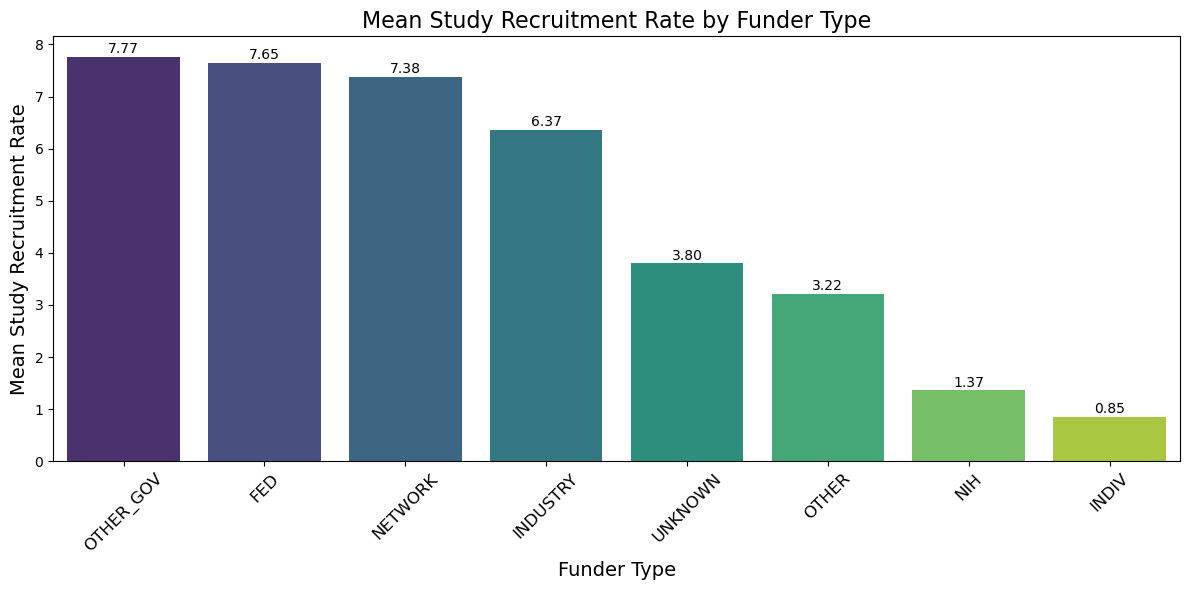

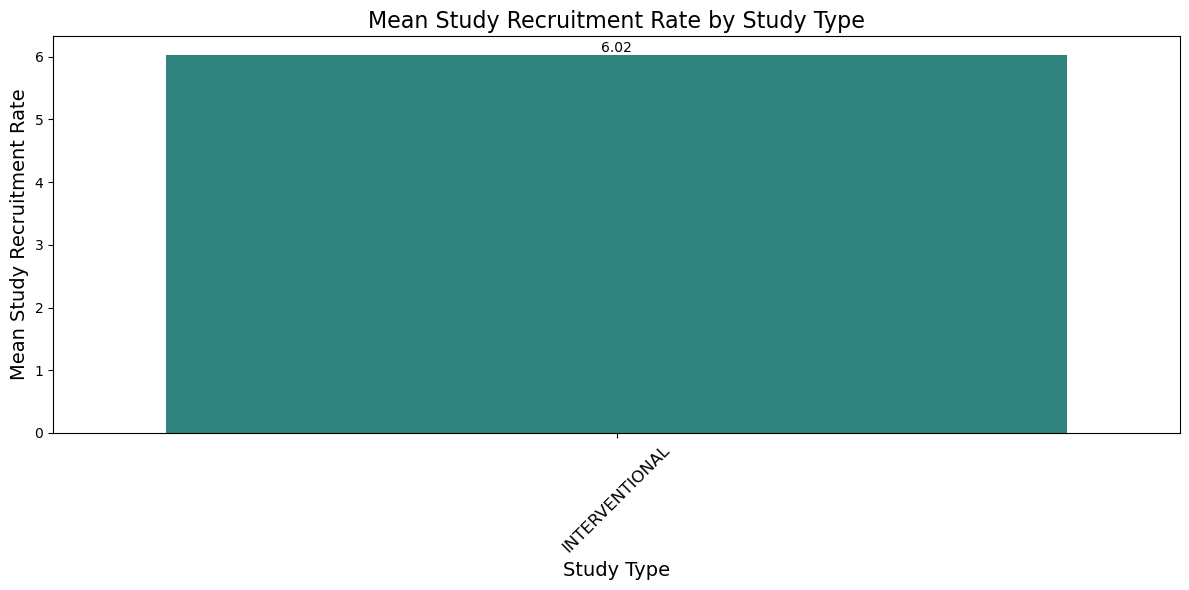

In [20]:
# List of columns to analyze
columns_to_analyze = ['Study Status', 'Study Results', 'Sex', 'Age', 'Phases', 'Funder Type', 'Study Type']

# Define a function to calculate mean and plot bar graphs with annotations
def plot_mean_recruitment_rate(dataframe, target_column, group_columns):
    # Ensure the target column is numeric
    dataframe[target_column] = pd.to_numeric(dataframe[target_column], errors='coerce')

    for col in group_columns:
        if col in dataframe.columns:  # Ensure the column exists in the dataframe
            # Drop rows where target column has NaN values after conversion
            valid_data = dataframe[[col, target_column]].dropna()

            # Skip if the column does not contain valid data
            if valid_data.empty:
                print(f"No valid data to analyze for column: {col}")
                continue

            # Calculate the mean recruitment rate for each group
            mean_recruitment_rate = valid_data.groupby(col)[target_column].mean().sort_values(ascending=False)

            # Create a bar plot
            plt.figure(figsize=(12, 6))
            sns.barplot(x=mean_recruitment_rate.index, y=mean_recruitment_rate.values, palette="viridis")

            # Annotate mean values on the bar
            for idx, value in enumerate(mean_recruitment_rate.values):
                plt.text(idx, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')

            # Add titles and labels
            plt.title(f'Mean {target_column} by {col}', fontsize=16)
            plt.xlabel(col, fontsize=14)
            plt.ylabel(f'Mean {target_column}', fontsize=14)
            plt.xticks(rotation=45, fontsize=12)
            plt.tight_layout()
            plt.show()

# Example usage
# Assuming your dataframe is called `df` and the recruitment rate column is named 'Recruitment Rate'
plot_mean_recruitment_rate(train, 'Study Recruitment Rate', columns_to_analyze)

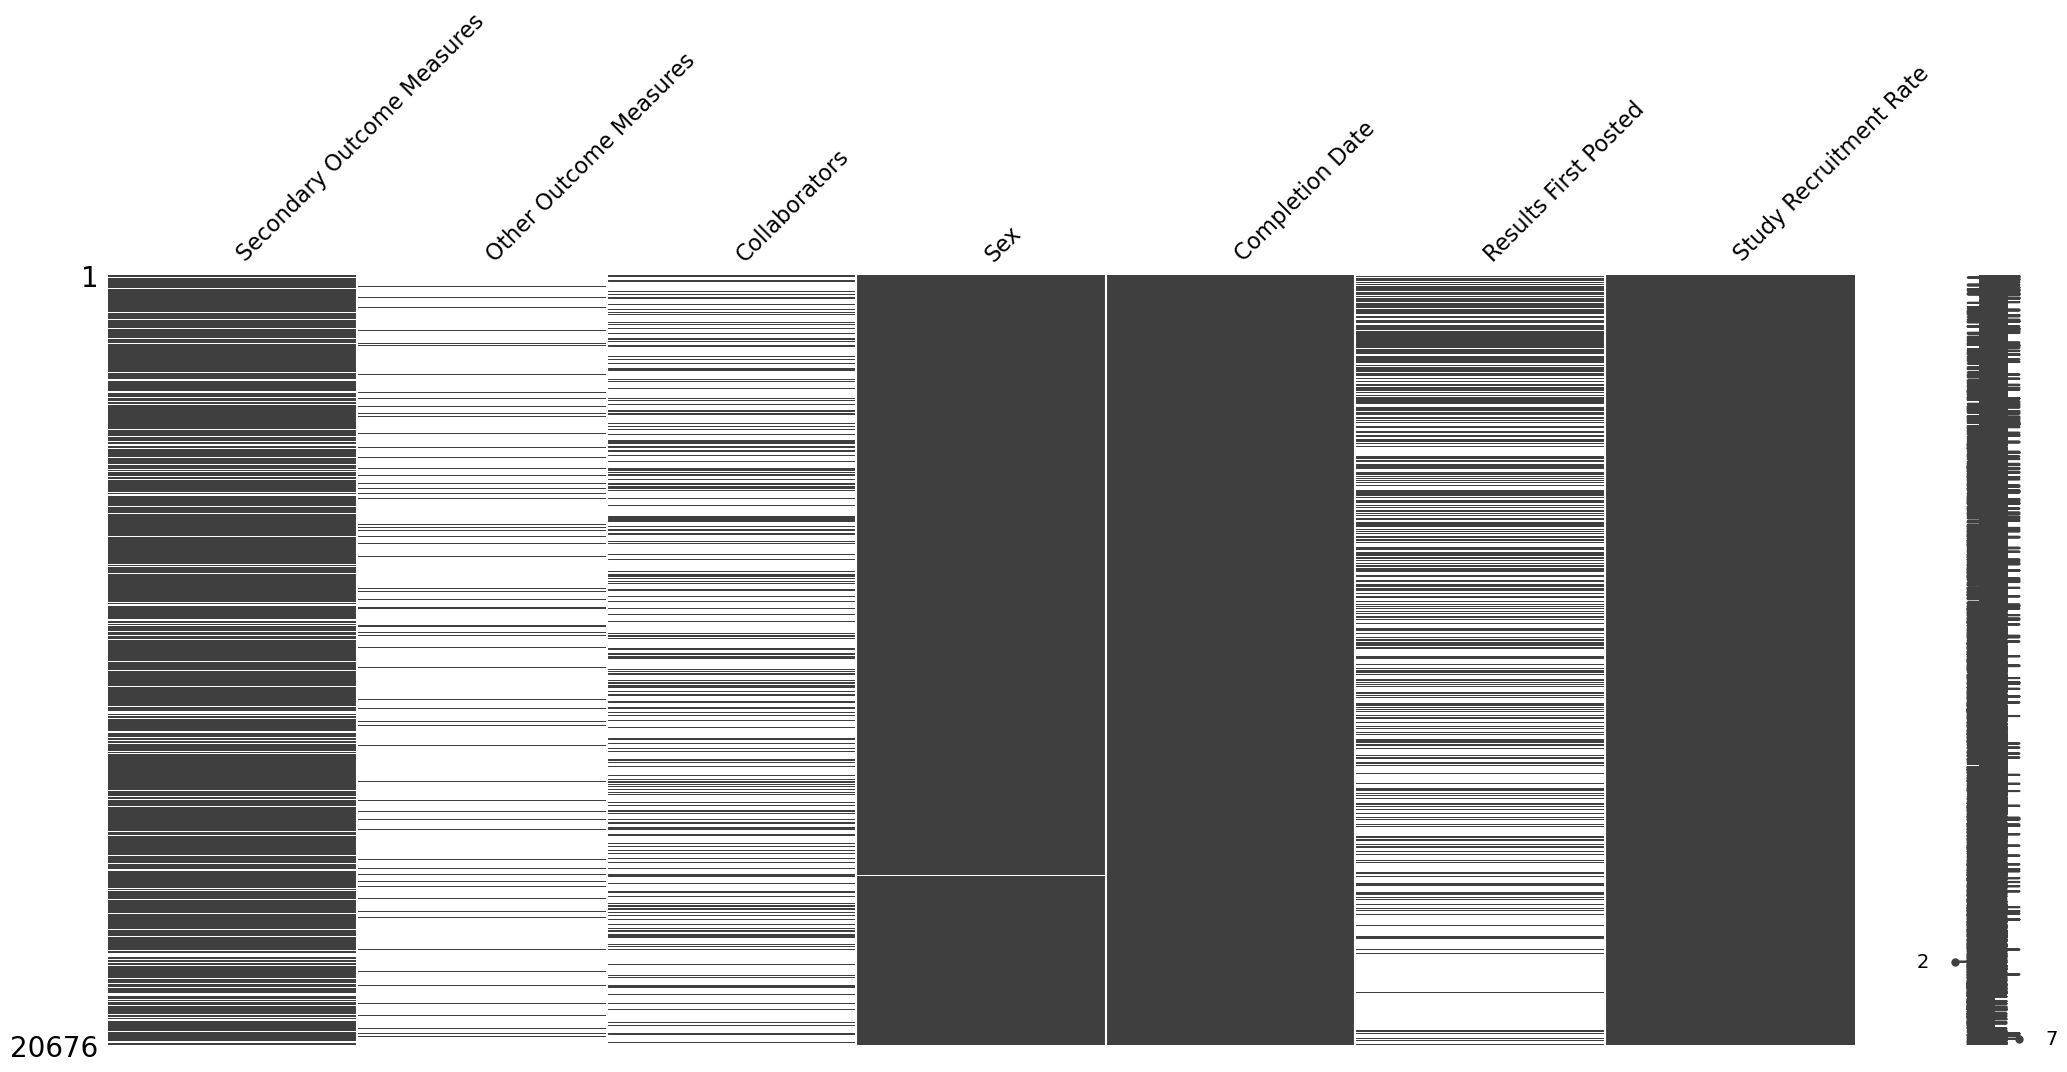

In [24]:
missing_cols = [col for col in train.columns if (train[col].isnull().any()) & (col != "target")]
msno.matrix(train[missing_cols]);

C:\Users\prateek singh\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


ValueError: could not convert string to float: '--'

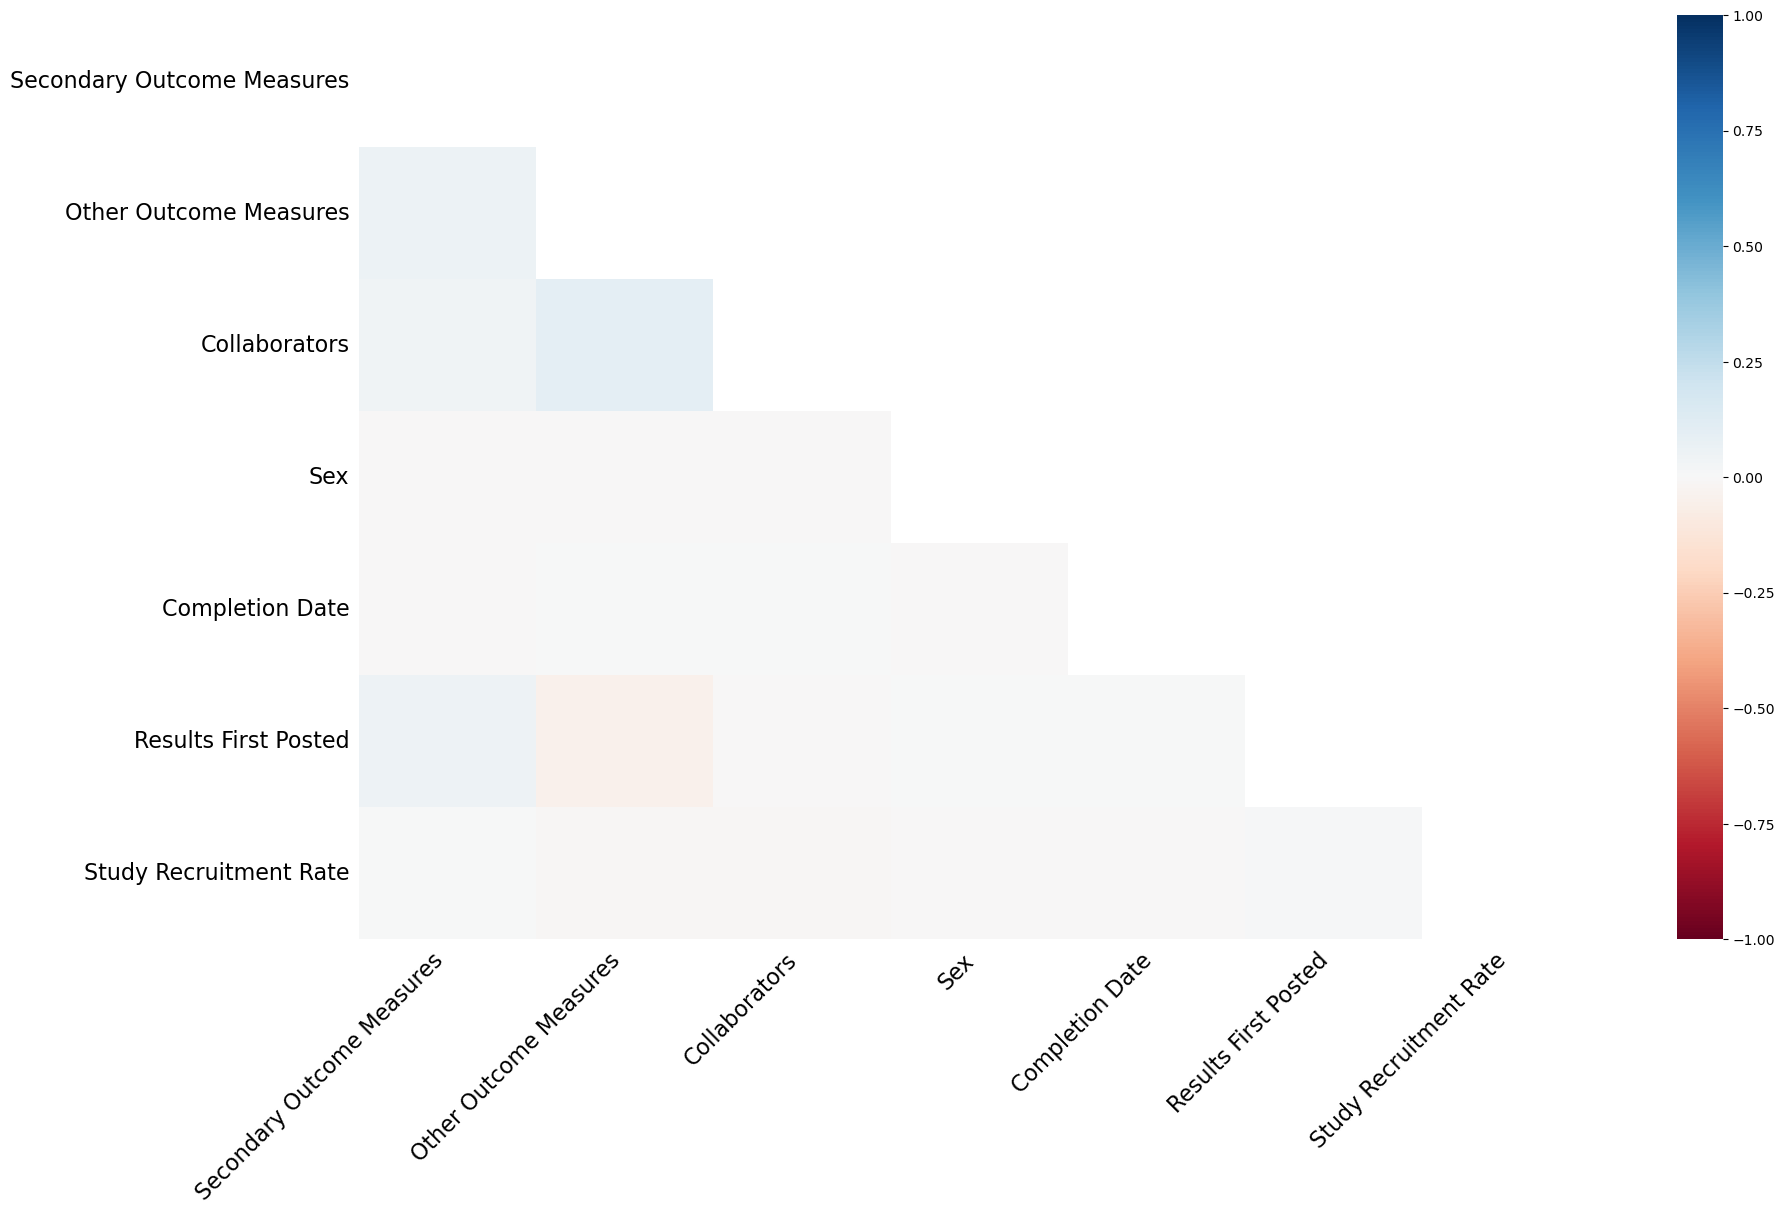

In [26]:
msno.heatmap(train[missing_cols]);

KeyError: 'target'